# Perceptron multicapa

El perceptrón multicapa en su descripción más básica es un algoritmo, que recibe variables y en función de unos parámetros entrega un resultado, este resultado es la clasificación de un objeto en función de las variables propias del objeto. La siguiente imagen corresponde a un perceptrón de una capa, con tres variables independientes y tres parámetros libres (w).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Hyper parámetros

In [2]:
num_workers = 0
batch_size = 20
valid_size = 0.2

In [3]:
transform = transforms.ToTensor()

## Construcción de los subsets de training y testing

In [4]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [5]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

In [6]:
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## Visualización de los datos

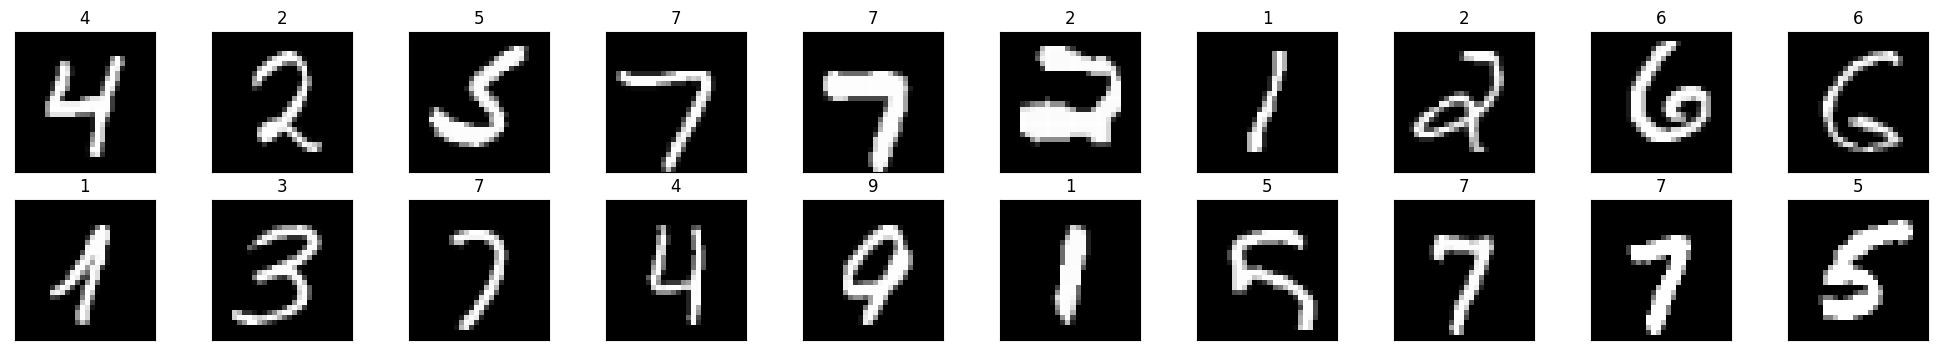

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

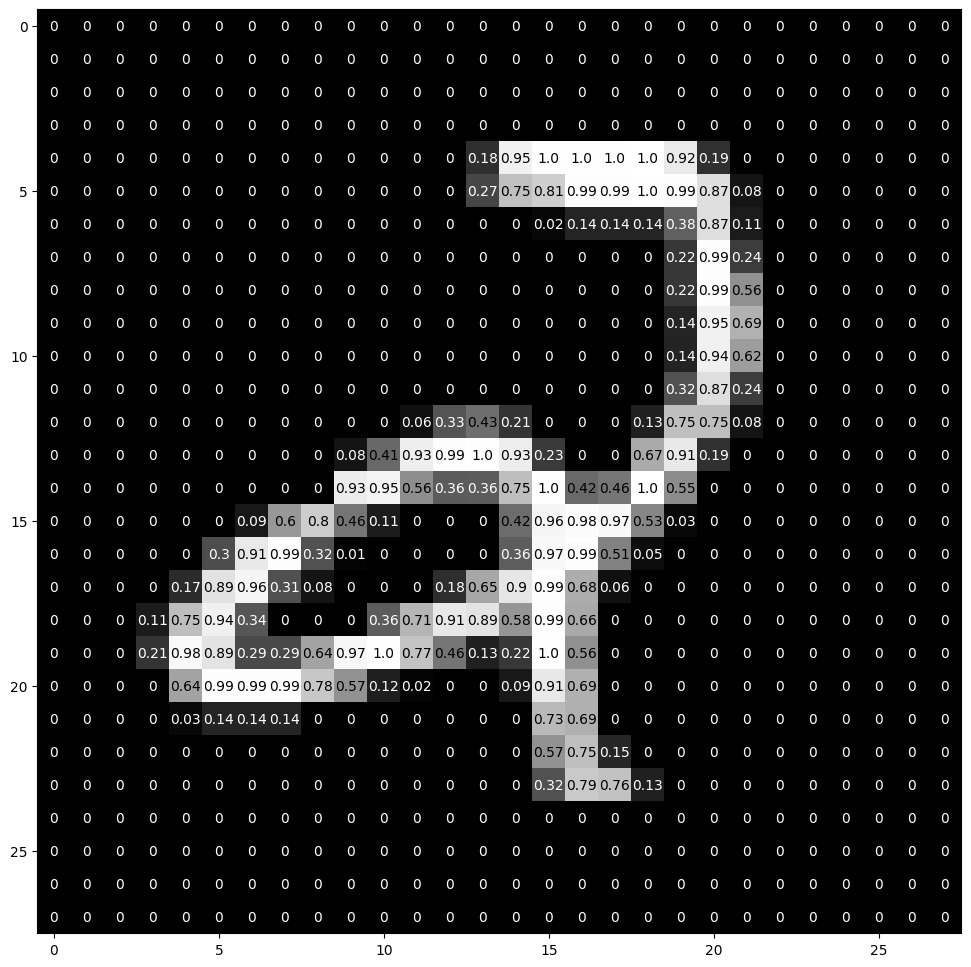

In [9]:
img = np.squeeze(images[7])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Red Neuronal

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,10)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


## Optimización

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

## Entrenamiento de la red neuronal

In [12]:
n_epochs = 10
valid_loss_min = np.Inf
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0

    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data,label in valid_loader:
        output = model(data)
        loss = criterion(output,label)
        valid_loss = loss.item() * data.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.932415 	Validation Loss: 0.000242
Validation loss decreased (inf --> 0.000242).  Saving model ...
Epoch: 2 	Training Loss: 0.356061 	Validation Loss: 0.000117
Validation loss decreased (0.000242 --> 0.000117).  Saving model ...
Epoch: 3 	Training Loss: 0.281431 	Validation Loss: 0.000093
Validation loss decreased (0.000117 --> 0.000093).  Saving model ...
Epoch: 4 	Training Loss: 0.233216 	Validation Loss: 0.000191
Epoch: 5 	Training Loss: 0.198762 	Validation Loss: 0.000038
Validation loss decreased (0.000093 --> 0.000038).  Saving model ...
Epoch: 6 	Training Loss: 0.170847 	Validation Loss: 0.000015
Validation loss decreased (0.000038 --> 0.000015).  Saving model ...
Epoch: 7 	Training Loss: 0.150739 	Validation Loss: 0.000017
Epoch: 8 	Training Loss: 0.134528 	Validation Loss: 0.000026
Epoch: 9 	Training Loss: 0.120091 	Validation Loss: 0.000013
Validation loss decreased (0.000015 --> 0.000013).  Saving model ...
Epoch: 10 	Training Loss: 0.109627 	Valida

## Validación del modelo

In [13]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)')
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.106944

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 98% (1120/1135)
Test Accuracy of     2: 96% (1000/1032)
Test Accuracy of     3: 97% (981/1010)
Test Accuracy of     4: 96% (946/982)
Test Accuracy of     5: 94% (846/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 95% (984/1028)
Test Accuracy of     8: 95% (931/974)
Test Accuracy of     9: 95% (965/1009)

Test Accuracy (Overall): 96% (9673/10000)


## Visualización de los resultados

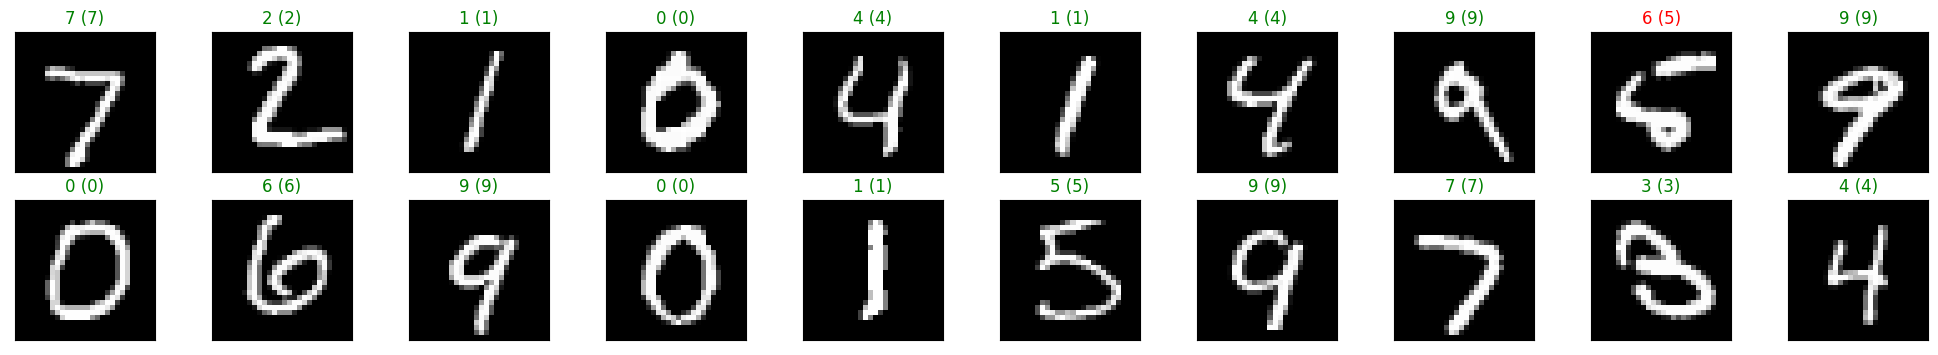

In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                color=("green" if preds[idx]==labels[idx] else "red"))